<a href="https://colab.research.google.com/github/nisaodabas/CNG483-Project2/blob/master/CNG483_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model  
from keras.utils import np_utils
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from google.colab import output
from google.colab import drive

drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def createDataSet(path):
    df = pd.read_csv(path, sep='\n')
    data = np.array(df)

    #print(data)
    numAttr = 0
    rows = []
    for row in data:        
        found = row[0].find("@ATTRIBUTE")
        if(found != -1):
            numAttr += 1
        else:
            # ignore @ATTRIBUTE rows
            rows.append(row[0].split(","))

    # delete @DATA row
    rows = np.array(rows[1:])

    labels = rows[:, -1].astype('int')
    
    labels = np.array([x - 1 for x in labels])

    if(numAttr == 6):
        features = rows[:, :numAttr-1].astype('float')
    else:
        features = rows[:, :numAttr-1].astype('int')
        # define feature selection
        #fs = SelectKBest(score_func=f_classif, k=4000)
        # apply feature selection
        #features = fs.fit_transform(features, labels)
        

    return features, labels

In [0]:
def model(X, y, dim):
    
    # define model
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
    
    
    model = Sequential()
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(36, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))
    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    #mc = ModelCheckpoint('/content/drive/My Drive/CNG483-Project 2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    numEpochs = 3000
    batches = 64
 
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=1 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    
    
    
    
    #history = model.fit(X_train, y_train, epochs=numEpochs, batch_size=batches, validation_data=(X_val, y_val), verbose=0)

    #print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    #return model

In [0]:
def gridSearch(X, y):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    # define the grid search parameters
    batch_size = [10, 20, 40, 60, 80, 100]
    epochs = [10, 50, 100]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
if __name__ == "__main__":
    geometic_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TestingSet.txt"
    geometic_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TrainingSet.txt"

    texture_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TestingSet.txt"
    texture_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TrainingSet.txt"


    geo_x_train, geo_y_train = createDataSet(geometic_train_path)
    geo_x_test, geo_y_test = createDataSet(geometic_test_path)

    txtr_x_train, txtr_y_train = createDataSet(texture_train_path)
    txtr_x_test, txtr_y_test = createDataSet(texture_test_path)


In [0]:
    all_x_train = np.concatenate((txtr_x_train, geo_x_train), axis=1)
    

Epoch 1/3000
15/15 [==============================] - 0s 18ms/step - loss: 1.1097 - acc: 0.2667 - val_loss: 1.0905 - val_acc: 0.3493
Epoch 2/3000
15/15 [==============================] - 0s 11ms/step - loss: 1.0767 - acc: 0.3814 - val_loss: 1.0599 - val_acc: 0.3493
Epoch 3/3000
15/15 [==============================] - 0s 11ms/step - loss: 1.0416 - acc: 0.4667 - val_loss: 1.0269 - val_acc: 0.5721
Epoch 4/3000
15/15 [==============================] - 0s 11ms/step - loss: 1.0194 - acc: 0.4940 - val_loss: 0.9991 - val_acc: 0.5721
Epoch 5/3000
15/15 [==============================] - 0s 12ms/step - loss: 0.9959 - acc: 0.5355 - val_loss: 0.9736 - val_acc: 0.5721
Epoch 6/3000
15/15 [==============================] - 0s 11ms/step - loss: 0.9749 - acc: 0.5454 - val_loss: 0.9510 - val_acc: 0.5721
Epoch 7/3000
15/15 [==============================] - 0s 11ms/step - loss: 0.9587 - acc: 0.5628 - val_loss: 0.9339 - val_acc: 0.5721
Epoch 8/3000
15/15 [==============================] - 0s 11ms/step - 

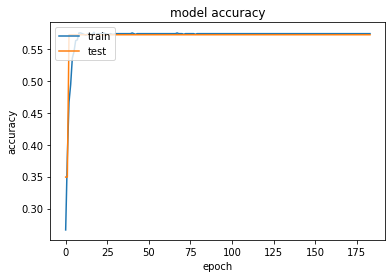

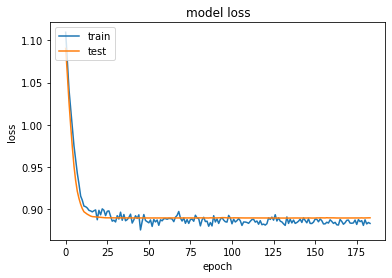

'\nestimator = KerasClassifier(build_fn=model, epochs=975, batch_size=128, verbose=0)\nkfold = KFold(n_splits=5, shuffle=True, random_state=1)\nresults = cross_val_score(estimator, all_x_train, txtr_y_train, cv=kfold, scoring=\'accuracy\')\n\nprint("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))\n'

In [43]:
    #model(txtr_x_train, txtr_y_train, 9600)
    #model(geo_x_train, geo_y_train, 5)
    model(all_x_train, txtr_y_train, 9605)

    #conv1d(txtr_x_train, txtr_y_train, 9600)


    '''
    estimator = KerasClassifier(build_fn=model, epochs=975, batch_size=128, verbose=0)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    results = cross_val_score(estimator, all_x_train, txtr_y_train, cv=kfold, scoring='accuracy')

    print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    '''


In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')